# UCLA WBB vs. USC (2025 Season) - Analytics Deep Dive

**Project by Abby Seseri**

### Objective

This project analyzes the play-by-play data from the three matchups between UCLA and USC during the 2025 season. The goal is to move beyond the box score to uncover deeper insights into individual player and lineup effectiveness.

### 1\. Setup and Data Loading

First, import the necessary libraries, define the teams configuration, and load the play-by-play dataset.

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [69]:
# --- Team Configuration ---
ucla_starters = ["Angela Dugalic", "Lauren Betts", "Gabriela Jaquez", "Londynn Jones", "Kiki Rice"]
usc_starters = ["Kiki Iriafen", "Rayah Marshall", "Kennedy Smith", "JuJu Watkins", "Talia von Oelhoffen"]
ucla_roster = ["Angela Dugalic", "Lauren Betts", "Gabriela Jaquez", "Londynn Jones", "Kiki Rice", "Janiah Barker", "Timea Gardiner", "Kendall Dudley", "Elina Aarnisalo"]
usc_roster = ["Kiki Iriafen", "Rayah Marshall", "Kennedy Smith", "JuJu Watkins", "Talia von Oelhoffen", "Vivian Iwuchukwu", "Clarice Akunwafo", "Brooklyn Shamblin", "Avery Howell", "Kayleigh Heckel", "Rian Forestier", "Malia Samuels", "Aaliyah Gayles"]

In [70]:
try:
    df = pd.read_csv('2025USCvsUCLA.csv')
except FileNotFoundError:
    print("Error: '2025USCvsUCLA.csv' not found. Please ensure the file is in the same directory.")

print("Data loaded successfully. First 5 rows:")
print(df.head())

Data loaded successfully. First 5 rows:
    time                  play_by_play  UCLA  USC  quarter               date
0  10:00                    Start game     0    0        1  February 13, 2025
1   9:58          Jump Ball won by USC     0    0        1  February 13, 2025
2   9:58        Jump Ball lost by UCLA     0    0        1  February 13, 2025
3   9:43   JuJu Watkins missed Jumper.     0    0        1  February 13, 2025
4   9:38  Kiki Rice Defensive Rebound.     0    0        1  February 13, 2025


### 2\. Analysis 1: Individual Player On-Court Impact (+/-)

The most fundamental player impact metric is **plus-minus (+/-)**. This metric reveals the team's point differential when a specific player is on the court. A high positive number indicates that the team significantly outscores the opponent when that player is playing.

The code below iterates through every play, tracks substitutions to know who is on the court, and attributes the point differential from each play to the five players on the floor.


In [71]:
# --- On-Court Plus-Minus Calculation ---
plus_minus = {player: 0 for player in ucla_roster}
on_court = set()
current_date = None
prev_ucla_score = 0
prev_usc_score = 0

for index, row in df.iterrows():
    if row['date'] != current_date:
        current_date = row['date']
        on_court = set(ucla_starters)
        prev_ucla_score = 0
        prev_usc_score = 0

    play = str(row['play_by_play'])

    # Substitution handling
    if "subbing in for UCLA" in play:
        for player in ucla_roster:
            if player in play: on_court.add(player)
    if "subbing out for UCLA" in play:
        for player in ucla_roster:
            if player in play: on_court.discard(player)

    # Point attribution
    delta_ucla = row['UCLA'] - prev_ucla_score
    delta_usc = row['USC'] - prev_usc_score
    if len(on_court) == 5:
        if delta_ucla > 0:
            for player in on_court: plus_minus[player] += delta_ucla
        elif delta_usc > 0:
            for player in on_court: plus_minus[player] -= delta_usc

    prev_ucla_score, prev_usc_score = row['UCLA'], row['USC']


--- Individual Plus-Minus Results ---
            Player  PlusMinus
7   Kendall Dudley          5
4        Kiki Rice         -1
6   Timea Gardiner         -4
2  Gabriela Jaquez         -7
5    Janiah Barker         -8
1     Lauren Betts        -10
0   Angela Dugalic        -11
8  Elina Aarnisalo        -21
3    Londynn Jones        -28

Chart saved as 'ucla_wbb_plus_minus_final.png'


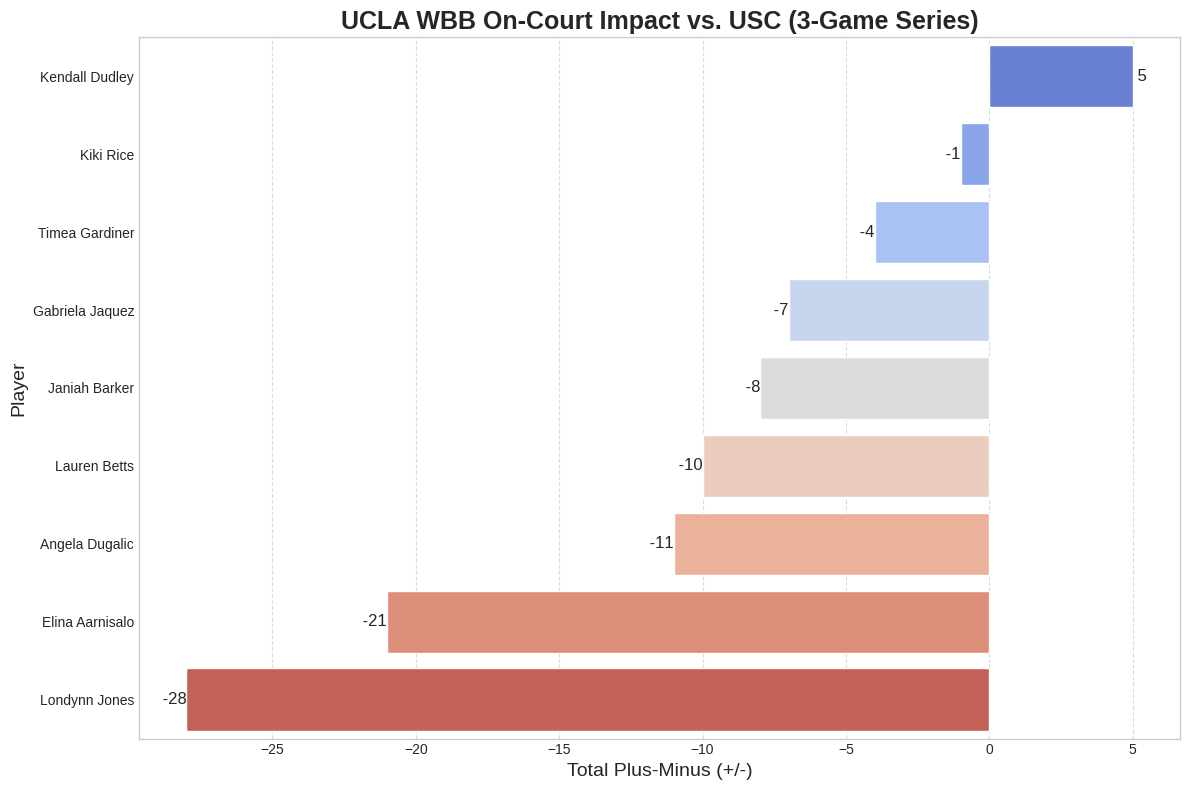

In [72]:
# --- Visualization: Individual Plus-Minus ---
pm_df = pd.DataFrame(list(plus_minus.items()), columns=['Player', 'PlusMinus'])
active_players = [p for p, pm in plus_minus.items() if pm != 0 or p in ucla_starters]
pm_df = pm_df[pm_df['Player'].isin(active_players)].sort_values('PlusMinus', ascending=False)

print("\n--- Individual Plus-Minus Results ---")
print(pm_df)

plt.figure(figsize=(12, 8))
sns.barplot(x='PlusMinus', y='Player', data=pm_df, hue='Player', palette='coolwarm', orient='h', legend=False)
plt.title('UCLA WBB On-Court Impact vs. USC (3-Game Series)', fontsize=18, fontweight='bold')
plt.xlabel('Total Plus-Minus (+/-)', fontsize=14)
plt.ylabel('Player', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
for i, val in enumerate(pm_df['PlusMinus']):
    plt.text(val, i, f' {val}', va='center', ha='left' if val >= 0 else 'right', fontsize=12)
plt.tight_layout()
plt.savefig('ucla_wbb_plus_minus_final.png', dpi=300)
print("\nChart saved as 'ucla_wbb_plus_minus_final.png'")
plt.show()

### 3\. Analysis 2: Lineup Effectiveness

While individual stats are useful, basketball is a team game. This analysis calculates the collective plus-minus for each unique 5-player lineup. To provide a more insightful comparison between lineups with different playing times, the data is normalized to **Plus-Minus per 5 Minutes**. This metric estimates a lineup's impact over a standard period of play.

To ensure the insights are meaningful, this analysis only includes lineups that played a minimum of two minutes together across the series.

In [73]:
# --- Data Preparation for Time-Based Analysis ---
def get_seconds_elapsed(row):
    time_parts = str(row['time']).split(':')
    minutes = int(time_parts[0])
    seconds = int(time_parts[1])
    quarter = int(row['quarter'])
    seconds_past_in_quarter = 600 - (minutes * 60 + seconds)
    return ((quarter - 1) * 600) + seconds_past_in_quarter

df['game_seconds'] = df.apply(get_seconds_elapsed, axis=1)
df_sorted = df.sort_values(by=['date', 'game_seconds']).reset_index(drop=True)

In [74]:
# --- Lineup Analysis Calculation ---
lineup_stats = {}
on_court = set()
current_date, last_event_time, prev_ucla_score, prev_usc_score = None, 0, 0, 0

for index, row in df_sorted.iterrows():
    if row['date'] != current_date:
        current_date = row['date']
        on_court = set(ucla_starters)
        last_event_time, prev_ucla_score, prev_usc_score = 0, 0, 0

    time_diff = row['game_seconds'] - last_event_time
    current_lineup_key = frozenset(on_court)
    if len(current_lineup_key) == 5:
        if current_lineup_key not in lineup_stats:
            lineup_stats[current_lineup_key] = {'plus_minus': 0, 'seconds_played': 0}
        lineup_stats[current_lineup_key]['seconds_played'] += time_diff

    score_diff = (row['UCLA'] - prev_ucla_score) - (row['USC'] - prev_usc_score)
    if len(current_lineup_key) == 5:
        lineup_stats[current_lineup_key]['plus_minus'] += score_diff

    play = str(row['play_by_play'])
    if "subbing in for UCLA" in play:
        for player in ucla_roster:
            if player in play: on_court.add(player)
    if "subbing out for UCLA" in play:
        for player in ucla_roster:
            if player in play: on_court.discard(player)
    last_event_time, prev_ucla_score, prev_usc_score = row['game_seconds'], row['UCLA'], row['USC']


--- Most Effective Lineups (>= 2 mins played) ---
                                           lineup_str  minutes_played  \
0   Elina Aarnisalo, Janiah Barker, Kiki Rice, Lau...        3.350000   
1   Gabriela Jaquez, Janiah Barker, Kiki Rice, Lau...        9.750000   
2   Angela Dugalic, Gabriela Jaquez, Kendall Dudle...        2.233333   
3   Angela Dugalic, Kiki Rice, Lauren Betts, Londy...        4.516667   
4   Gabriela Jaquez, Kiki Rice, Lauren Betts, Lond...        3.266667   
5   Angela Dugalic, Gabriela Jaquez, Janiah Barker...        2.600000   
6   Angela Dugalic, Gabriela Jaquez, Kiki Rice, La...       55.450000   
7   Gabriela Jaquez, Janiah Barker, Kiki Rice, Lau...       13.350000   
8   Janiah Barker, Kiki Rice, Lauren Betts, Londyn...        3.683333   
9   Elina Aarnisalo, Gabriela Jaquez, Kiki Rice, L...        3.066667   
10  Angela Dugalic, Elina Aarnisalo, Gabriela Jaqu...        2.783333   
11  Elina Aarnisalo, Janiah Barker, Lauren Betts, ...        3.350000   


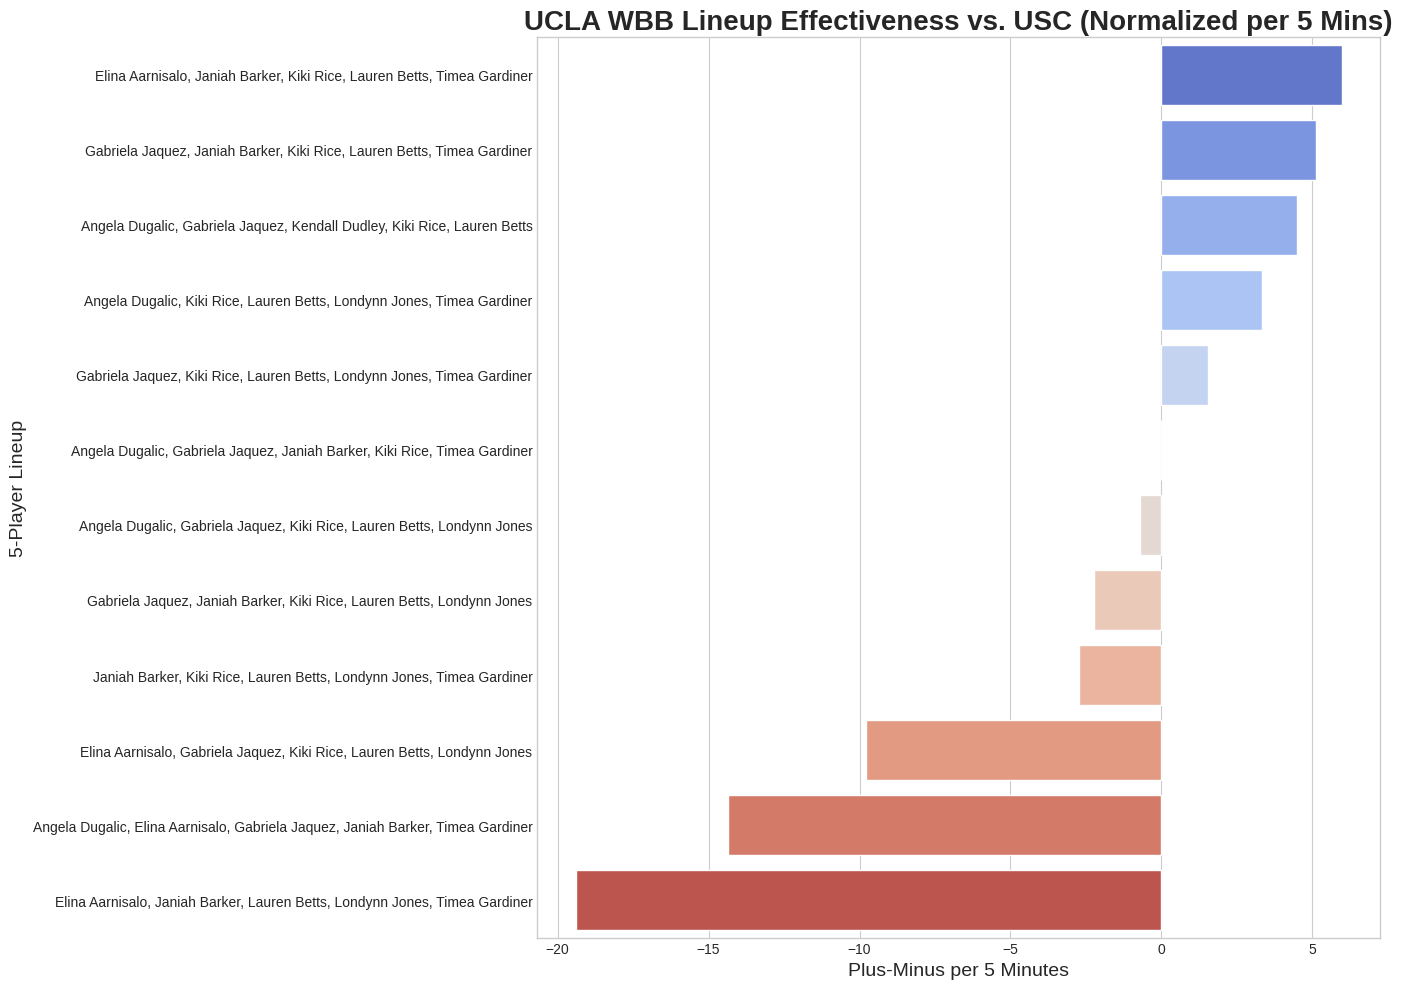

In [75]:
# --- Visualization: Lineup Effectiveness ---
lineup_df = pd.DataFrame.from_dict(lineup_stats, orient='index')
lineup_df['minutes_played'] = lineup_df['seconds_played'] / 60
lineup_df = lineup_df[lineup_df['minutes_played'] >= 2].copy()
# Calculate the advanced metric
lineup_df['pm_per_5_min'] = (lineup_df['plus_minus'] / lineup_df['minutes_played']) * 5
lineup_df['lineup_str'] = [', '.join(sorted(list(x))) for x in lineup_df.index]
lineup_df = lineup_df.sort_values('pm_per_5_min', ascending=False)
lineup_df = lineup_df.reset_index(drop=True)

print("\n--- Most Effective Lineups (>= 2 mins played) ---")
print(lineup_df[['lineup_str', 'minutes_played', 'plus_minus', 'pm_per_5_min']])

plt.figure(figsize=(14, 10))
sns.barplot(x='pm_per_5_min', y='lineup_str', data=lineup_df, hue="lineup_str", palette='coolwarm', orient='h', legend=False)
plt.title('UCLA WBB Lineup Effectiveness vs. USC (Normalized per 5 Mins)', fontsize=20, fontweight='bold')
plt.xlabel('Plus-Minus per 5 Minutes', fontsize=14)
plt.ylabel('5-Player Lineup', fontsize=14)
plt.tight_layout()
plt.savefig('ucla_wbb_lineup_analysis.png', dpi=300)
print("\nChart saved as 'ucla_wbb_lineup_analysis.png'")
plt.show()

### **4. Key Findings & Conclusion**

This analysis of the three-game series against USC provides a quantitative foundation for strategic coaching decisions. While individual plus-minus offers a top-level view of player impact, a deeper dive into lineup data reveals more specific and actionable insights.

* **Key Insight: A Highly Potent Lineup Combination:** The normalized data reveals a particularly potent combination that consistently outperformed the opposition. The lineup of **Elina Aarnisalo, Janiah Barker, Kiki Rice, Lauren Betts, and Timea Gardiner** was UCLA's most effective unit on a per-minute basis. Despite potentially limited minutes together, their performance indicates an elite level of efficiency and chemistry.

### Actionable Insight

The data strongly suggests that the **Aarnisalo-Barker-Rice-Betts-Gardiner** lineup is a significant strategic asset. Exploring increased playing time for this specific five-player unit, particularly in high-leverage situations or when the offense needs a spark, could provide a considerable advantage in future matchups.

This project demonstrates the power of play-by-play data to move beyond traditional box scores and identify the specific player synergies that drive competitive success.